In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
import csv

In [20]:
# Init global variables
cho_len = 30157507 - 2 #This will be replaced with the output from "zcat chr<n>.txt.gz | wc -l" - 2 in script
ch = '18'

In [3]:
# Init data paths
biobank = r"path/chr"+ch+".txt.gz"
gff = r"path/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20221007.gff"
excl = r"/path/variant_exclusions_.txt"

In [4]:
def get_hgReg(gff: str):
    """
    A function for reading and preparing the gene catalogue
    used for annotation.
    
    ----------------------
    gff str:
        The path to of the human genome regulatory build.
        
    ----------------------
    hg pandas.DataFrame:
        The prepared data.
    """
    # Read regulatory build gff file    
    hg = pd.read_csv(gff, sep='\t', header=None)

    # Turn aggregate column to separate columns
    hg[['id', 'bound_end', 'bound_start', 'description', 'feature_type']] = hg[8].str.split(';', 4, expand=True)

    # Remove unnecessary section from column values
    hg['id'] = hg['id'].str.replace('ID=','')
    hg['bound_end'] = hg['bound_end'].str.replace('bound_end=','')
    hg['bound_start'] = hg['bound_start'].str.replace('bound_start=','')
    hg['description'] = hg['description'].str.replace('description=','')
    hg['feature_type'] = hg['feature_type'].str.replace('feature_type=','')

    # Delete unnecessary column
    hg.drop([8], axis=1, inplace=True)

    # Rename columns
    hg.rename(columns={0:'seqname', 1:'source', 2:'type', 3:'start', 
                       4:'end', 5:'score', 6:'strand', 7:'phase'}, inplace=True)
    
    return hg

# Get regulatory data
hg = get_hgReg(gff)

In [ ]:
# Init position variables
adding = 10000000
begin = 2
end=0

# Init annotation list
annot = []

# Init the while loop iterration number
ind = 0

# Get hg subgroup for chromosome and sort by start position
hg10 = hg[hg['seqname']==ch]
hg10 = hg10.to_numpy()
hg10 = hg10[hg10[:,3].argsort()]

# Annotating
while(end!=cho_len):
    # Check and update end position for iterration     
    if begin == 2:
        end = begin + adding
    elif end+adding < cho_len:
        end = end+adding
    else:
        end = cho_len
        
    # Init ukb data list   
    ukb = []
    
    # Read ukb data from set start pos to end pos
    with gzip.open(biobank, 'rt') as f:
        reader = csv.reader(f, delimiter='\t')
        for i, row in enumerate(reader):
            if i < begin:
                continue
            if i > end:
                break
            ukb.append(row)

    # remove unneeded columns, fix column types and sort by pos
    ukb = np.array(ukb, dtype=object)
    ukb = np.delete(ukb, [5,6], axis=1)
    ukb[:,3] = ukb[:,3].astype(int)
    ukb = ukb[ukb[:,3].argsort()]

    # Initialise the row removal list
    to_del = []
    print("read file it:" + str(ind + 1))
    
    # Check position and annotate
    for r in hg10:
        ukb = np.delete(ukb, to_del, axis=0)
        d = 0
        to_del = []
        for row in ukb:
            if row[3]<r[3]:
                to_del.append(d)
            elif r[3]<=row[3] and r[4]>=row[3]:
                annot.append(np.append(row, r))
            elif row[3]>r[4]:
                break
            d = d + 1
    
    # Print positions
    print(begin)
    print(end)
    
    # Inc iterration counter
    ind = ind + 1
    
    # Save annotation file
    np.savetxt('ch'+ch+str(ind)+'.tsv', np.asarray(annot), delimiter='\t', fmt="%s")
    
    # Reset list for next iterration
    annot = []
    
    # Update start position for next iterration
    begin = end + 1
    


In [7]:
# numpy to pandas
annot = pd.DataFrame(annot)

In [21]:
# Read saved annotated file if needed
annot=None

size=1000000
it = pd.read_csv('./annotations/ch'+ch+'.tsv.gz', chunksize=size, sep='\t', 
                 compression='gzip', header=None)
for chunk in it:
    annot = pd.concat([annot, chunk])
    print(len(annot), end=" ")


1000000 2000000 3000000 4000000 5000000 6000000 7000000 8000000 9000000 10000000 10064091 

In [22]:
# Make sure the format of column 2 is correct
annot[2]=annot[2].astype(str).apply(lambda x: 'chr'+x if x.isnumeric() else x)

In [ ]:
'''
For running without excluded variants, skip the next two cells and 
change plot and file names (remove the ex/filt at the end).
'''

In [ ]:
# Read exclusion file
exc = pd.read_csv(excl, sep='\t', header=None)
exc = exc[0]
exc = exc.apply(lambda x: 'chr' + x)

In [ ]:
# Remove variants in exclusion file from annot
annot = annot[~annot[0].isin(exc)]

# save file
annot.to_csv("./path/filtered_chr"+ch+".tsv.gz", sep="\t", compression='gzip')

In [ ]:
# Remove unneeded columns, group by variant id, 
# aggregate columns and have different region types (if more than one) in same row e.g promoter enhancer
# remove duplicates (there will be several rows with the same values after so we remove dups)
# save tsv
annot.drop([5,8,9,10,11,12,14,15,16,17], axis=1).groupby(0).agg({1:'first', 2:'first', 
                                                                 3:'first', 4:'first', 
                                                                 6:'first', 7:' '.join, 13:' '.join
}).reset_index().drop_duplicates(subset=[0]).to_csv("./path/filt_ch"+ch+"_no_dup.tsv.gz", sep="\t", compression='gzip')

In [36]:
# Get count of each type
type_count = annot[7].value_counts()

# Get length of annot
leng = len(annot)


In [37]:
# Get precentage annotated 
all_len = cho_len - 1
print((len(annot)/(all_len))*100)

16.624478518120604


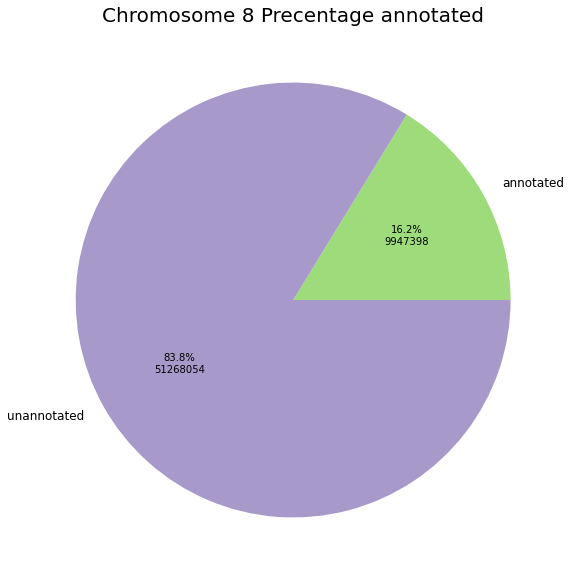

In [27]:
# plot for precentage annotated
def fmt(x):
    """
    Function for getting the values to write on the plot.
    -------------
    x float:
        The precentage of the value in the annotations.
    """
    return '{:.1f}%\n{:.0f}'.format(x, all_len * x / 100)

# Init variables and lables to plot
x = [len(annot), all_len-len(annot)]
label = ['annotated', 'unannotated']

# Create precentage annotated plot
colors = ['#9edb7b','#a799c9','#a9e4f5']
fig, ax = plt.subplots(1,1,figsize=(10, 10))
patches, texts, pcts = ax.pie(x, colors=colors, labels=label, autopct=fmt)
plt.setp(texts, fontsize=12)

# Save plot with and without title
plt.savefig('./path/ch'+ch+'_precent_annot_pie_notitle_ex.png', format='png', bbox_inches='tight')
ax.set_title('Chromosome ' + ch +' Precentage annotated', fontsize=20)
plt.savefig('./path/ch'+ch+'_precent_annot_pie_ex.png', format='png', bbox_inches='tight')

In [38]:
# Get variants in more than one region
dups = annot[0].value_counts()
ukbdups = dups[dups>1]
ukbdups = ukbdups.to_frame().reset_index()

In [29]:
# Init list of overlapping regions in ukbdups
rep_list = []

# Get duplicate values list
reps = ukbdups['index'].values
# Sort annot region type based on variant name
arr = annot[[0,7]].sort_values(0)
# Only keep variants that fall into more than one region
arr = arr[arr[0].isin(reps)]

# Get values and fill list (we skip every other row as both promoter enhancer, enhacer promoter exist)
for i in range(0,len(arr),2):
    rep_list.append(tuple(sorted((arr[7].iloc[i], arr[7].iloc[i+1]))))

# Get dup type count
dup_counts = {}
for item in rep_list:
    if item in dup_counts:
        dup_counts[item] += 1
    else:
        dup_counts[item] = 1

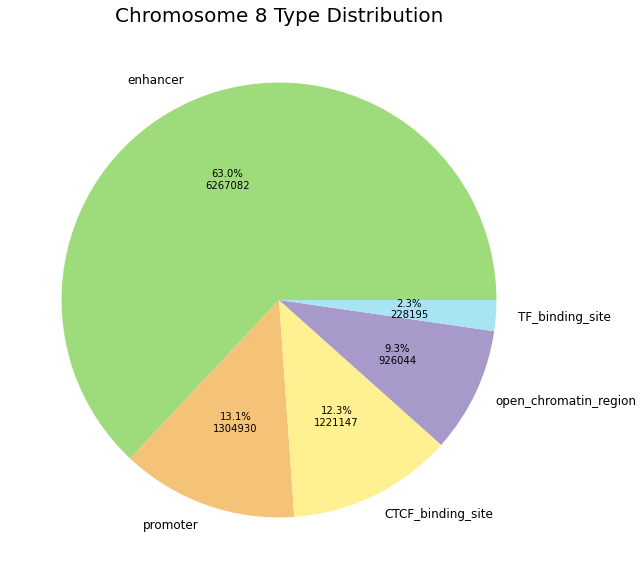

In [30]:
# plot for element type distribution 
def fmt(x):
    """
    Function for getting the values to write on the plot.
    -------------
    x float:
        The precentage of the value in the annotations.
    """
    return '{:.1f}%\n{:.0f}'.format(x, leng * x / 100)

# Draw type distribution pie chart
colors = ['#9edb7b','#f5c378','#fff091','#a799c9','#a9e4f5']
fig, ax = plt.subplots(1,1,figsize=(10, 10))
patches, texts, pcts = ax.pie(type_count.values, colors=colors, labels=type_count.index, autopct=fmt)
plt.setp(texts, fontsize=12)

# Save plot with and without a title
plt.savefig('./path/ch'+ch+'_rtype_pie_notitle_ex.png', format='png', bbox_inches='tight')
ax.set_title('Chromosome '+ch+' Type Distribution', fontsize=20)
plt.savefig('./path/ch'+ch+'_rtype_pie_ex.png', format='png', bbox_inches='tight')


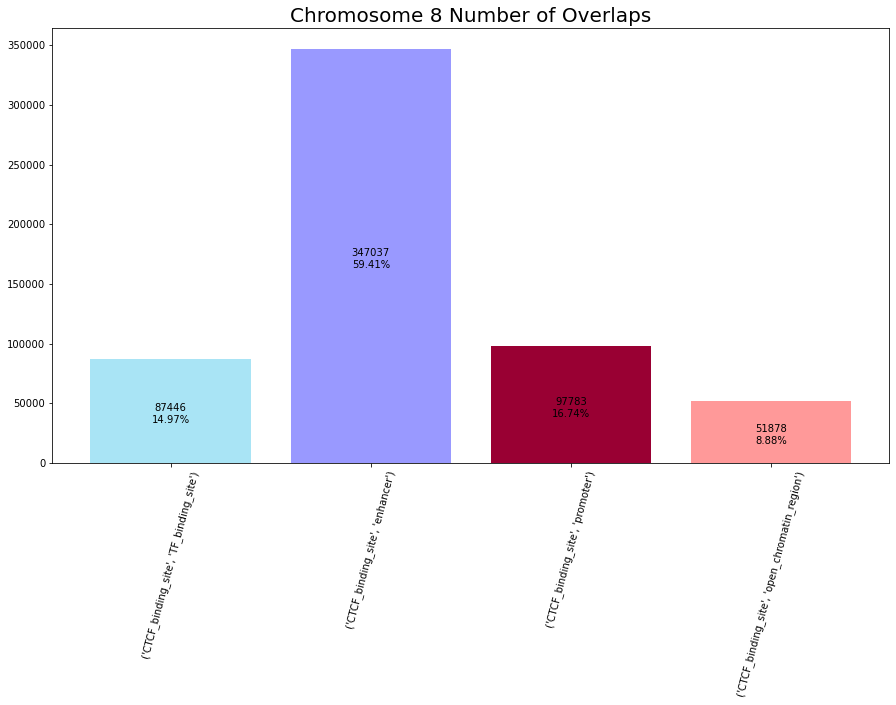

In [31]:
# Plot overlap element-type counts
'''
In the future for consistency, you can sort the regulatory elements 
by name before plotting to have the same order for all plots.
'''
fig, ax = plt.subplots(1,1,figsize=(15, 8))
colors = ['#a9e4f5', '#9999ff', "#990033", "#ff9999"]
plt.xticks(rotation=75)
ax.bar(x=[str(i) for i in dup_counts.keys()], height=dup_counts.values(),color=colors)

# Numbers on bars
vals = list(dup_counts.values())
# set how much lower the precentage value should be written
dist = 10000
for i in range(len(dup_counts)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')
    plt.text(i, vals[i]/2 - dist, f"{((vals[i]/len(ukbdups))*100):.2f}%", ha='center')

# Save plot with and without a title
plt.savefig('./path/ch'+ch+'_dup_type_notitle_ex.png', format='png', bbox_inches='tight')
ax.set_title('Chromosome '+ch+' Number of Overlaps', fontsize=20)
plt.savefig('./path/ch'+ch+'_dup_type_ex.png', format='png', bbox_inches='tight')

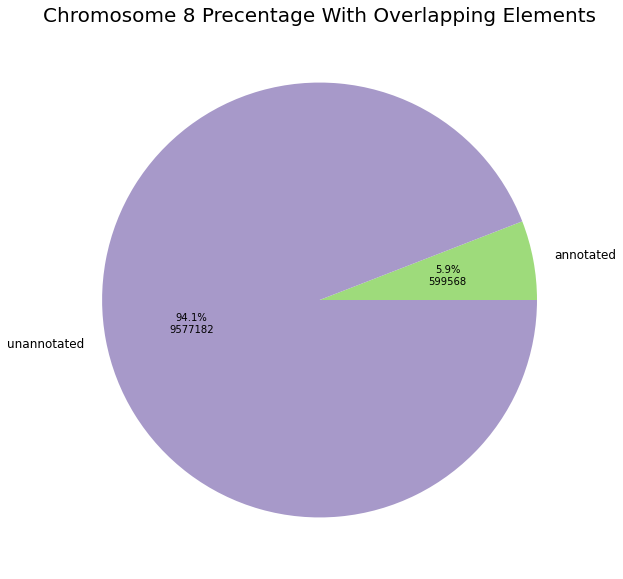

In [39]:
# plot for precentage of overlapping elements
def fmt(x):
    """
    Function for getting the values to write on the plot.
    -------------
    x float:
        The precentage of the value in the annotations.
    """
    return '{:.1f}%\n{:.0f}'.format(x, len(annot) * x / 100)

# Init variables and lables to plot
x = [len(ukbdups), len(annot)-len(ukbdups)]
label = ['annotated', 'unannotated']

# Create precentage annotated plot
colors = ['#9edb7b','#a799c9','#a9e4f5']
fig, ax = plt.subplots(1,1,figsize=(10, 10))
patches, texts, pcts = ax.pie(x, colors=colors, labels=label, autopct=fmt)
plt.setp(texts, fontsize=12)

# Save plot with and without title
plt.savefig('./path/ch'+ch+'_precent_dup_pie_notitle_ex.png', format='png', bbox_inches='tight')
ax.set_title('Chromosome ' + ch +' Precentage With Overlapping Elements', fontsize=20)
plt.savefig('./path/ch'+ch+'_precent_dup_annot_pie_ex.png', format='png', bbox_inches='tight')

In [20]:
# check values of score, strand and phase
print(annot[10].unique())
print(annot[11].unique())
print(annot[12].unique())


['.']
['.']
['.']
